In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

import networkx as nx

from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.correction import RoomAreas

%matplotlib inline

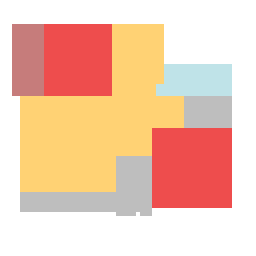

<PlanMasks 139491302870704>

In [28]:
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
pm

In [39]:
%%time

min_area_units = 10
rooms = []
for i, node in enumerate(pm.graph.nodes):
    if not NodeType.is_room(node):
        continue

    room = RoomAreas(node, pm.masks[i])
    room.threshold_rectangles(min_area_units)
    rooms.append(room)

CPU times: user 821 ms, sys: 3.38 ms, total: 825 ms
Wall time: 827 ms


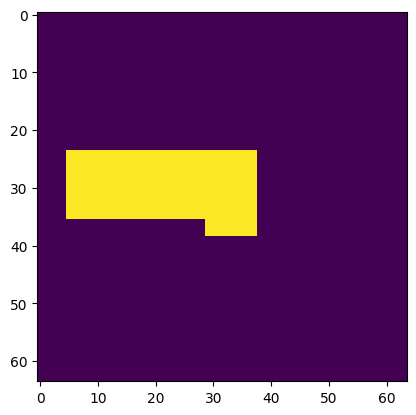

In [40]:
plt.imshow(rooms[3].to_mask())